In [166]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['portland-oregon-average-monthly-.csv']


In [167]:
df = pd.read_csv('../input/portland-oregon-average-monthly-.csv', index_col=0)
df.index.name=None
df.reset_index(inplace=True)
df.drop(df.index[114], inplace=True)

In [168]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,114)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [169]:
df.columns= ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)
df.shape

(114, 1)

In [170]:
df.head()

,riders
1973-01-01,64800
1973-02-01,64600
1973-03-01,63900
1973-04-01,65400
1973-05-01,63000


In [171]:
data = [
    go.Scatter(
        y=df.riders,
        x=df.index
        
    )
]
layout = go.Layout(title='Riders Count',
                  yaxis=dict(title='Rider Count'),
                  xaxis=dict(title='Years'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='order count')

## Time Series Analysis

In [172]:
ts = df["riders"] 
ts.head(10)

1973-01-01    64800
1973-02-01    64600
1973-03-01    63900
1973-04-01    65400
1973-05-01    63000
1973-06-01    62200
1973-07-01    61700
1973-08-01    61300
1973-09-01    66100
1973-10-01    69500
Name: riders, dtype: int64

In [173]:
ts['1978']

1978-01-01    128600
1978-02-01    128100
1978-03-01    122400
1978-04-01    128000
1978-05-01    122800
1978-06-01    118100
1978-07-01    115600
1978-08-01    112400
1978-09-01    115200
1978-10-01    120500
1978-11-01    126000
1978-12-01    118800
Name: riders, dtype: int64

## Stationarity Check

### Dickey Fuller Test

In [174]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(8,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

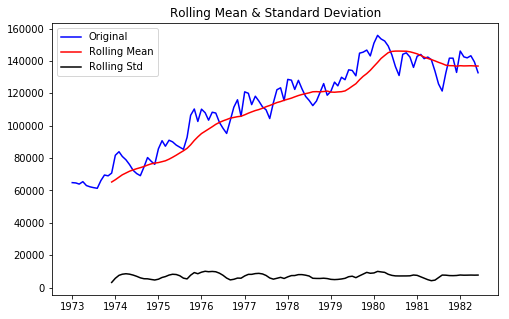

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [175]:
test_stationarity(ts)

### Using Log to get stationarity

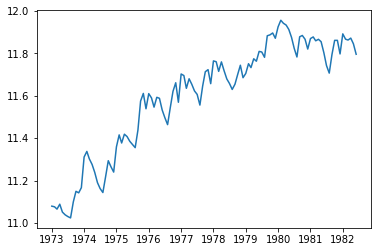

In [176]:
ts_log = np.log(ts)
plt.plot(ts_log)

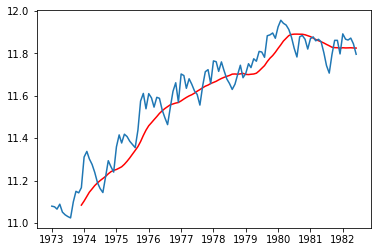

In [177]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

#### Case 1 : No subtraction

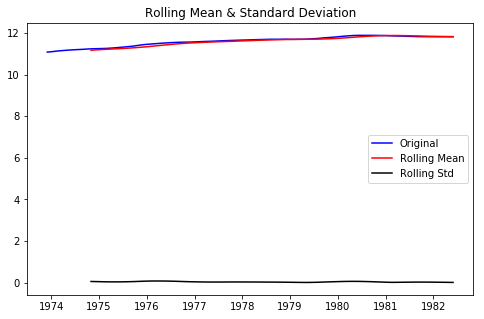

Results of Dickey-Fuller Test:
Test Statistic                  -1.806679
p-value                          0.377151
#Lags Used                       1.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [178]:
no_sub_ts = ts_smooth
no_sub_ts.dropna(inplace = True)
test_stationarity(no_sub_ts)

#### Case 2: Subtraction

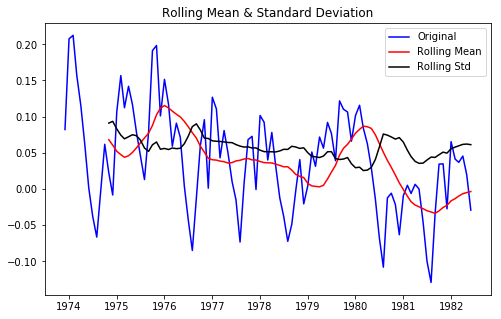

Results of Dickey-Fuller Test:
Test Statistic                 -2.579211
p-value                         0.097371
#Lags Used                     12.000000
Number of Observations Used    90.000000
Critical Value (1%)            -3.505190
Critical Value (5%)            -2.894232
Critical Value (10%)           -2.584210
dtype: float64


In [179]:
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)
test_stationarity(sub_ts)

### Exponential weighted average

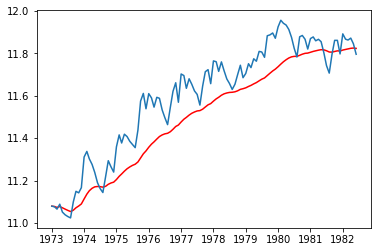

In [180]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(expwighted_avg, color='red')
plt.plot(ts_log)

#### Case 1: No subtraction

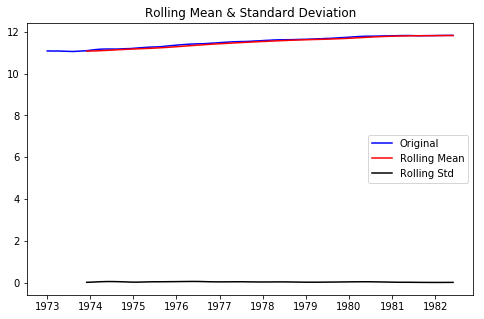

Results of Dickey-Fuller Test:
Test Statistic                  -1.344670
p-value                          0.608496
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In [181]:
no_sub_ts = expwighted_avg
no_sub_ts.dropna(inplace = True)
test_stationarity(no_sub_ts)

#### Case 2: Subtraction

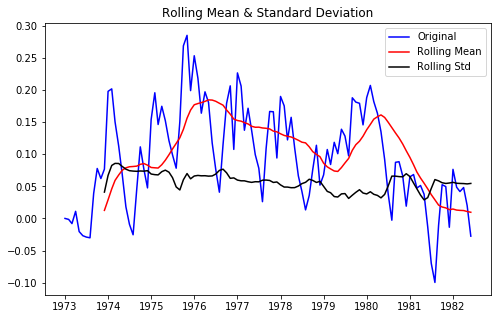

Results of Dickey-Fuller Test:
Test Statistic                  -1.598948
p-value                          0.484122
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [182]:
exp_ts_diff = ts_log-expwighted_avg
exp_ts_diff.dropna(inplace = True)
test_stationarity(exp_ts_diff)

### Differencing

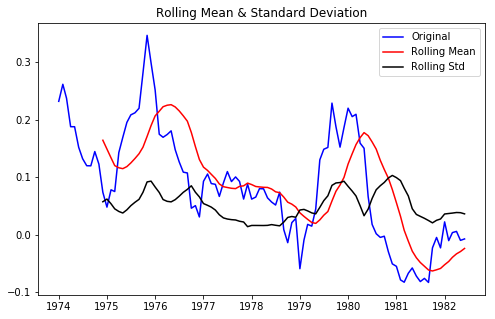

Results of Dickey-Fuller Test:
Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [183]:
ts_diff = ts_log - ts_log.shift(12)
ts_diff.dropna(inplace = True)
test_stationarity(ts_diff)

#### Differencing + Exponential weighting

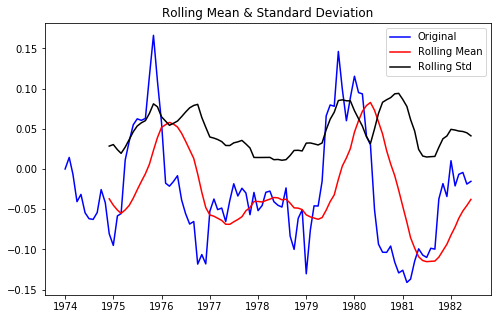

Results of Dickey-Fuller Test:
Test Statistic                 -4.300230
p-value                         0.000444
#Lags Used                      8.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [184]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

## Decomposition

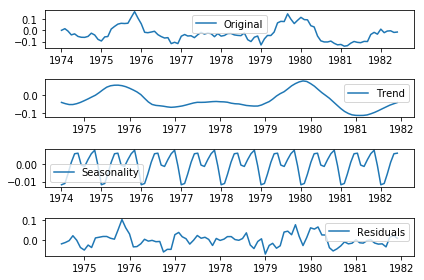

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_diff_exp)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_diff_exp, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Forecasting

### ARIMA model

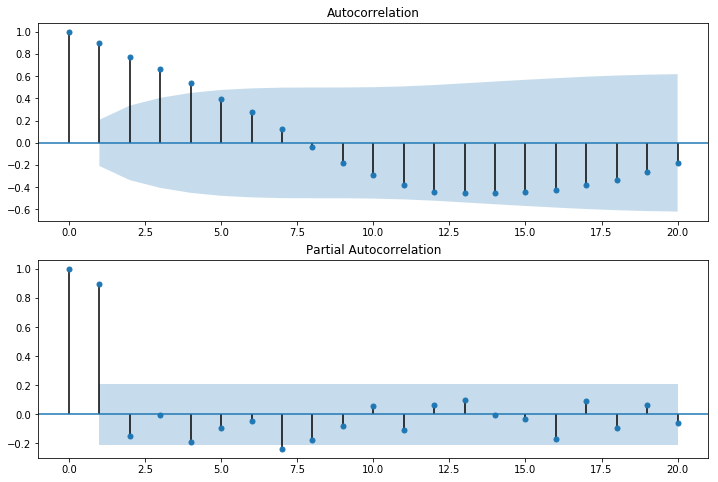

In [139]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff_exp.iloc[13:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff_exp.iloc[13:], lags=20, ax=ax2)

In [140]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df.riders,
                                            order=param,
                                            seasonal_order=param_seasonal
                                            )

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2219.6899414842032
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2213.84060681152
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2183.4696861054226
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2248.8865698857403
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1956.2709501553225
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:2227.481949968865
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:2197.1247254410832
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1956.9686061241975
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1946.514021856392
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:2278.9185303694007
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2250.9415868456827
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1958.8269417316312
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1958.3681008919507
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:2239.324049311397
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2198.6609875031727
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1958.9957079555638
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1950.6407023096926
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2059.96834457809

In [185]:
mod = sm.tsa.statespace.SARIMAX(df.riders, order=(0, 1,0 ), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Sat, 11 Aug 2018   AIC                           1946.514
Time:                                    03:49:08   BIC                           1954.723
Sample:                                01-01-1973   HQIC                          1949.845
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.9982      0.117   

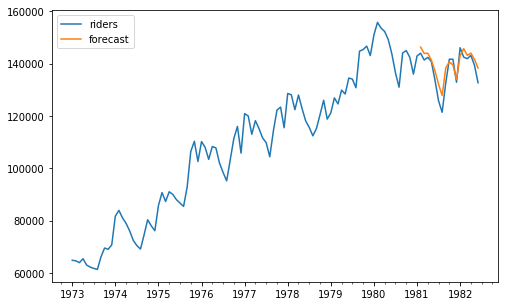

In [186]:
df['forecast'] = results.predict(start = 97, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(8, 5)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

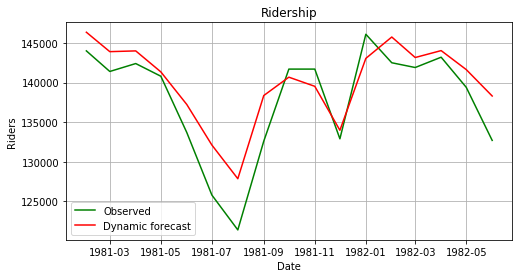

In [189]:
npredict =df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize=(8,4))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'g', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'r', label='Dynamic forecast')
ax.grid(True)
legend = ax.legend(loc='best')
legend.get_frame().set_facecolor('w')
plt.savefig('ts_predict_compare.png', bbox_inches='tight')

### Future Prediction

In [191]:
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

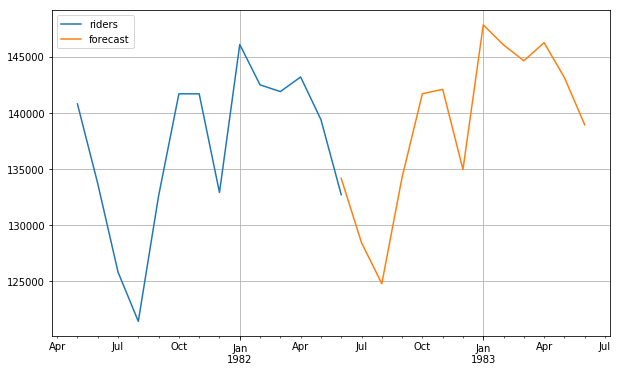

In [192]:
df['forecast'] = results.predict(start = 113, end = 140, dynamic= True)  
df[['riders', 'forecast']].ix[-26:].plot(figsize=(10, 6)) 
plt.grid(True)
plt.savefig('ts_predict_future.png', bbox_inches='tight')

We see that the number of riders increases when the new year starts due to everyone making new year resolutions and it gradually declines as the year passes.